


After some experiments with more traditional DS techniques, fast.AI was selected for ease of use, flexibility and performances.
Deep learning models are particularly useful for datasets with high cardinality categorical variables because they provide embeddings that can be used to train efficient models.

More info : https://www.mdpi.com/2078-2489/11/2/108

Kernel used is inspired by the tabular model described in lesson 4 of "Practical Deep Learning for Coders" course from Jeremy Howard.
More info : https://course.fast.ai/videos/?lesson=4

In [1]:
%matplotlib inline
import pandas as pd
from fastai.tabular import *
import fastai 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ml-challenge-week6/census-income.test
/kaggle/input/ml-challenge-week6/census-income.names
/kaggle/input/ml-challenge-week6/census-income.data
/kaggle/input/ml-challenge-week6/sampleSubmission.csv


In [2]:
# check version
fastai.__version__

'1.0.60'

In [3]:
# Feture importance extraction from NN weights
def feature_importance(learner): 
  # based on: https://medium.com/@mp.music93/neural-networks-feature-importance-with-fastai-5c393cf65815
    data = learner.data.train_ds.x
    cat_names = data.cat_names
    cont_names = data.cont_names
    loss0=np.array([learner.loss_func(learner.pred_batch(batch=(x,y.to("cpu"))), y.to("cpu")) for x,y in iter(learner.data.valid_dl)]).mean()
    fi=dict()
    types=[cat_names, cont_names]
    for j, t in enumerate(types):
      for i, c in enumerate(t):
        loss=[]
        for x,y in iter(learner.data.valid_dl):
          col=x[j][:,i] 
          idx = torch.randperm(col.nelement())
          x[j][:,i] = col.view(-1)[idx].view(col.size())
          y=y.to('cpu')
          loss.append(learner.loss_func(learner.pred_batch(batch=(x,y)), y))
        fi[c]=np.array(loss).mean()-loss0
    d = sorted(fi.items(), key=lambda kv: kv[1], reverse=True)
    return pd.DataFrame({'cols': [l for l, v in d], 'imp': np.log1p([v for l, v in d])})


# Part 1 : Data Ingestion & Basic Cleaning

We simply load data files, treat NaN and merge everything in a single dataframe. 

In [4]:
# load all datasets
col = ["age","class of worker","detailed industry recode","detailed occupation recode","education",
       "wage per hour","enroll in edu inst last wk","marital status","major industry code",
       "major occupation code","race","hispanic origin","sex","member of a labor union",
       "reason for unemployment","full or part time employment stat","capital gains","capital losses",
       "dividends from stocks","tax filer stat","region of previous residence","state of previous residence",
       "detailed household and family stat","detailed household summary in household","instance weight",
       "migration code-change in msa","migration code-change in reg","migration code-move within reg",
       "live in this house 1 year ago","migration prev res in sunbelt","num persons worked for employer",
       "family members under 18","country of birth father","country of birth mother","country of birth self",
       "citizenship","own business or self employed","fill inc questionnaire for veteran\'s admin",
       "veterans benefits","weeks worked in year","year","income class"]

df = pd.read_csv("../input/ml-challenge-week6/census-income.data", names=col, header=None)
print("Shape of Train dataframe is: {}".format(df.shape))
print('NaN in Train:',df.isnull().values.any())
test = pd.read_csv("../input/ml-challenge-week6/census-income.test", names=col[0:-1], header=None)
print("Shape of Test dataframe is: {}".format(test.shape))
print('NaN in Test:',test.isnull().values.any())
sub = pd.read_csv("../input/ml-challenge-week6/sampleSubmission.csv")
zub = sub['index']

Shape of Train dataframe is: (199523, 42)
NaN in Train: False
Shape of Test dataframe is: (99762, 41)
NaN in Test: True


In [5]:
# build inventory of categorical & continuous features
cat = ['class of worker', 'education', 'marital status', 'major industry code',
       'major occupation code', 'race','sex', 'reason for unemployment',
       'detailed household and family stat', 'detailed household summary in household']

cont = ['age', 'detailed occupation recode', 'capital gains', 'capital losses',
        'dividends from stocks', 'num persons worked for employer', 
        'veterans benefits', 'weeks worked in year'] # removed "instance weight"

# align features with test dataset...
for i in cat:
    df[i] = df[i].str[1:]    



In [6]:
# align test target
test['income class'] = ' - 50000.'
# NaN corrections in test dataset
test["hispanic origin"] = test["hispanic origin"].fillna('NA')
test["state of previous residence"] = test["state of previous residence"].fillna('?')
test['migration code-change in msa'] = test['migration code-change in msa'].fillna('?')
test['migration code-change in reg'] = test['migration code-change in reg'].fillna('?')
test['migration code-move within reg'] = test['migration code-move within reg'].fillna('?')
test['migration prev res in sunbelt'] = test['migration prev res in sunbelt'].fillna('?')
test['country of birth father'] = test['country of birth father'].fillna('?')
test['country of birth mother'] = test['country of birth mother'].fillna('?')
test['country of birth self'] = test['country of birth self'].fillna('?')

In [7]:
# merge train & test dataset
df = df.append(test, ignore_index = True)

In [8]:
# transform target in category type
df = df.join(pd.get_dummies(df['income class']))

# Part 2 : Split Train-Valid-Test using index

Since we have a single dataframe, we split it like this...

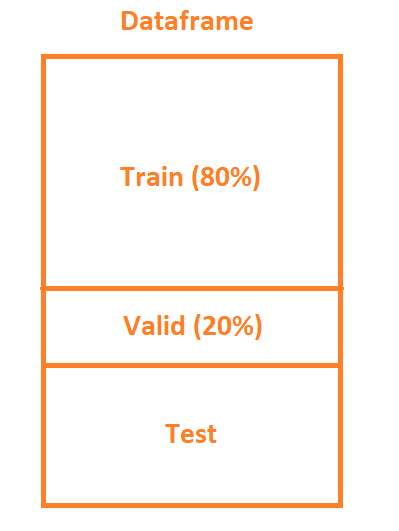

In [9]:
# parameters for NN model
dep_var =  ' 50000+.'
procs = [FillMissing, Categorify, Normalize]

In [10]:
# check % positive values in train set
df[dep_var].value_counts()[1]/199523

0.06205800834991455

In [11]:
# split by index
idx_test = df.iloc[199523:].index # last N rows
idx_val  = df.iloc[159619:199522].index # last 20% of train rows
idx_val, idx_test

(RangeIndex(start=159619, stop=199522, step=1),
 RangeIndex(start=199523, stop=299285, step=1))

In [12]:
# check % positive values in validation set
df.loc[idx_val, dep_var].value_counts()[1]/(199522-159619)

0.06367942259980452

In [13]:
# prepare databunch ingestion of test set
test = TabularList.from_df(df.loc[idx_test].copy(), path='', cat_names=cat, cont_names=cont)

In [14]:
# databunch ingestion of data sets

BS = 64

data = (TabularList.from_df(df, path='', cat_names=cat, cont_names=cont, procs=procs)
                           .split_by_idx(idx_val)
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())

data.batch_size = BS


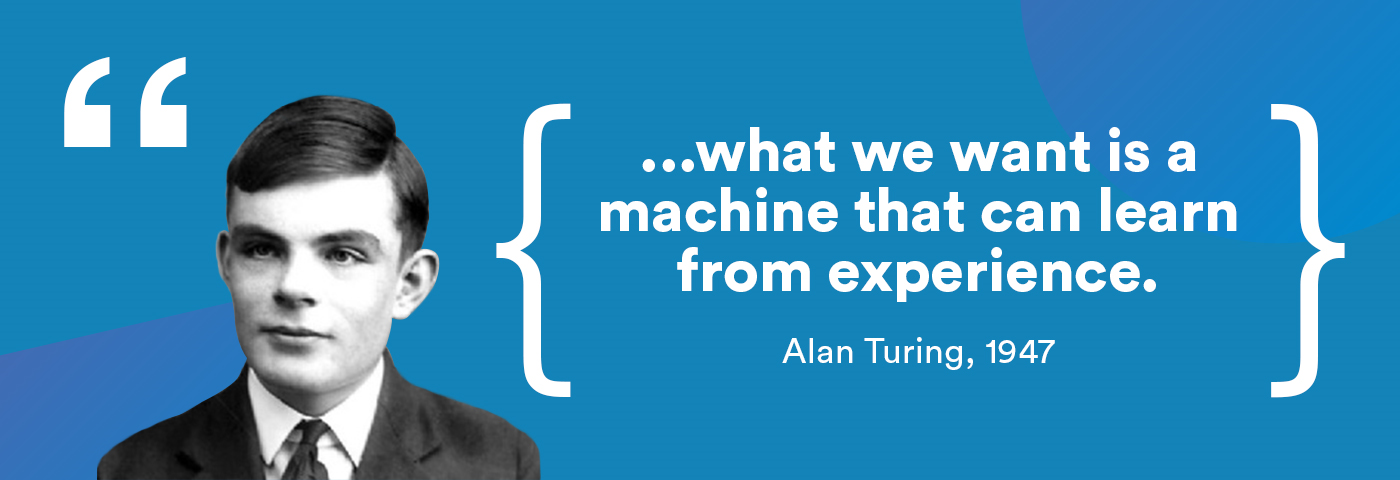

# Part 3 : Train NN Model

epoch,train_loss,valid_loss,accuracy,auroc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02
Min loss divided by 10: 4.37E-02


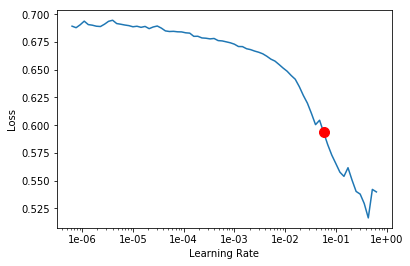

In [15]:
# build NN learner and look at learning rate curve
learn = tabular_learner(data, layers=[200,100], metrics=[accuracy, AUROC()],callback_fns=ShowGraph)

learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.104190,0.141138,0.944941,0.934367,01:14
1,0.100540,0.144237,0.942912,0.935921,01:14
2,0.101299,0.138249,0.941107,0.941116,01:14
3,0.105237,0.138597,0.942110,0.940844,01:15
4,0.103096,0.140898,0.942060,0.941297,01:15


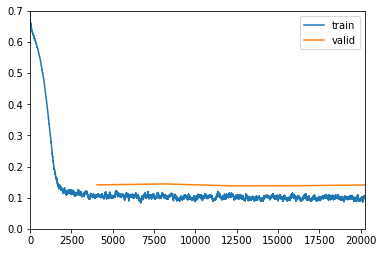

In [16]:
# Initial learning phase using suggested learning rate during 3 cycles
lr = 1e-03
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy,auroc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


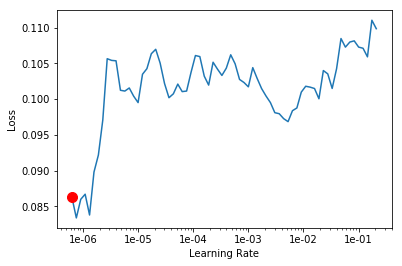

In [17]:
# look again at learning rate curve
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.090365,0.135668,0.944891,0.943136,01:14
1,0.099476,0.139639,0.942135,0.942255,01:15
2,0.090920,0.136763,0.943463,0.942345,01:15


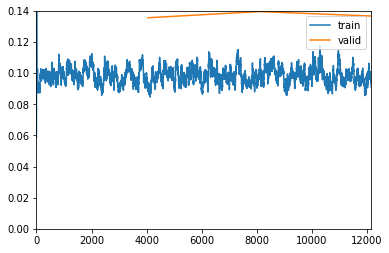

In [18]:
# 2nd learning phase using suggested learning rate during 3 cycles
learn.fit_one_cycle(3,max_lr=1e-8)


# Part 4 : Inception & build submission file

In [19]:
# predict test classes...
probas_test, _ = learn.get_preds(ds_type=DatasetType.Test) # run inference on test
probas_test = probas_test[:, 1] # only get probability tensor

In [20]:
# create submission dataframe
submission_df = pd.DataFrame({'index':sub.index.values,dep_var:probas_test})
submission_df.columns = ['index','income class']

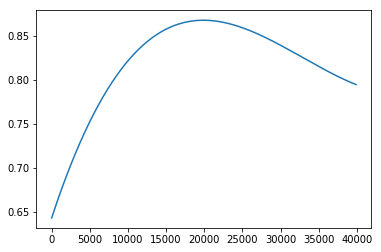

In [21]:
# get tp driver
tp = range(0,40000,100) 
y = []
for x in tp:
    y.append(0.6432042 + 0.00002635951*x - 9.49824e-10*x**2 + 9.629459e-15*x**3) # from my own analysis...
    
plt.plot(tp,y);

In [22]:
print('Best amount of true classes should be', np.argmax(y)*100,'with expected AUC arround',y[np.argmax(y)])

Best amount of true classes should be 19900 with expected AUC arround 0.867504551725941


In [23]:
# should have more positive classes, let's align...
pivot = .2
while len(submission_df[submission_df['income class']>=pivot])< 19100: #(np.argmax(y)*100):
    pivot = pivot-.000001
correction = .5 - pivot
print('Pivot is',pivot,'- tensor correction is', correction)

Pivot is 0.04260999999984261 - tensor correction is 0.4573900000001574


In [24]:
# apply correction, classify 0/1 and make it int
submission_df['income class'] = submission_df['income class'] + correction # tensor correction
submission_df['income class'] = submission_df['income class'].apply(np.round)
submission_df['income class'] = submission_df['income class'].astype(int)

In [25]:
# check results
submission_df.describe()

,index,income class
count,99762.000000,99762.000000
mean,49880.500000,0.191476
std,28798.953115,0.393465
min,0.000000,0.000000
25%,24940.250000,0.000000
50%,49880.500000,0.000000
75%,74820.750000,0.000000
max,99761.000000,1.000000


In [26]:

submission_df.to_csv('FastAI_v6_corrected.csv', index = False) #



# Annexes  Feature Importance & Lesson's Learned

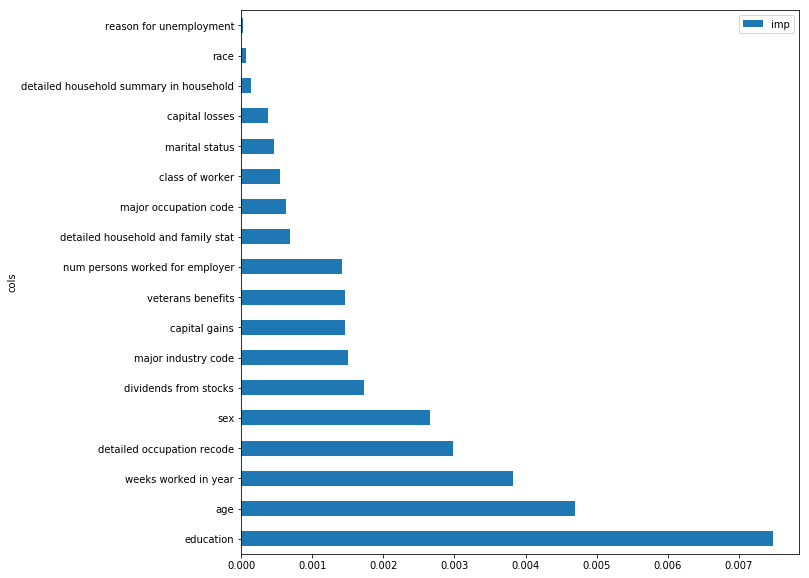

In [27]:
# Here are our NN feature importance 
fi = feature_importance(learn)
fi[:20].plot.barh(x="cols", y="imp", figsize=(10, 10))

# These improvements have been tested but don't give significant results:

### Under/Over sampling sampling to realign unbalanced class ratio.
### Incestuous learning (re-use some predicted classes to re balance train set).
### [5,8,10] Kfolds.
### Optimizers : Flatten and Anneal - Ranger - Mish.
### Custom metric (fbeta).


